In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pyproj



In [ ]:
df_rides = pd.read_pickle('df_rides')

In [59]:
df_rides.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,distance_Manhattan,Season,DayOfYear,DayOfWeek,hour,day,month,year,daylighthours,Holiday
id,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,1723.957684,1,74,0,17,14,3,2016,11.864576,False
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,2441.748555,2,164,6,0,12,6,2016,15.017241,False
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,8156.039197,1,19,1,11,19,1,2016,9.675665,False
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,1644.816109,2,97,2,19,6,4,2016,12.900760,False
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,1211.250987,1,86,5,13,26,3,2016,12.409669,False


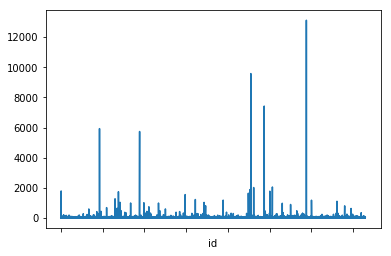

In [60]:
#df_rides['rides'] = (df_rides.distance_Manhattan / (df_rides['dropoff_datetime']-df_rides['pickup_datetime']) /  np.timedelta64(1, 's') ) 
df_rides['velo'] = (df_rides.distance_Manhattan / ((df_rides['dropoff_datetime']-df_rides['pickup_datetime']).dt.seconds))*3.6
df_rides.velo.plot()



In [61]:
#mask = df_rides[df_rides.velo]
# df_rides.query('velo')
df = df_rides.query("velo<=50&velo>0")

In [62]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'pickup_geom', 'dropoff_geom', 'pickup_x_utm', 'pickup_y_utm',
       'dropoff_x_utm', 'dropoff_y_utm', 'distance_Manhattan', 'Season',
       'DayOfYear', 'DayOfWeek', 'hour', 'day', 'month', 'year',
       'daylighthours', 'Holiday', 'velo'],
      dtype='object')

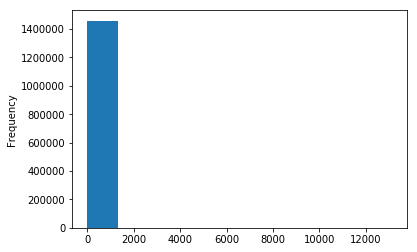

In [63]:
df_rides.velo.plot(x=df.velo,kind='hist')

In [64]:
df_rides.velo.describe()

count    1.458644e+06
mean     1.862509e+01
std      2.018464e+01
min      0.000000e+00
25%      1.150763e+01
50%      1.633721e+01
75%      2.310059e+01
max      1.311857e+04
Name: velo, dtype: float64

In [65]:
df.velo.describe()

count    1.428136e+06
mean     1.794779e+01
std      9.014185e+00
min      2.718036e-05
25%      1.148486e+01
50%      1.620385e+01
75%      2.267361e+01
max      4.999886e+01
Name: velo, dtype: float64

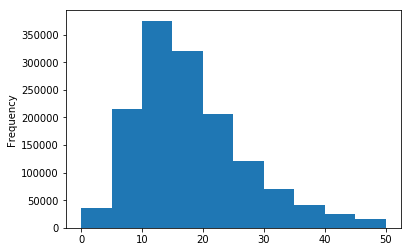

In [66]:
df.velo.plot(x=df.velo, kind='hist')

In [67]:
def ecdf(data):
    """
        This methods caculcates the x,y coordinates for an ecdf-plot

    parameters:
        data: numpy array of pandas series of data

    return parameters:
        sorted numpy array of values, numpy array of percentage of values below indexed value

    """
    if type(data) is np.ndarray:
        data = data[~np.isnan(data)]
        return np.sort(data), np.arange(1, len(data) + 1) / len(data)
    else:
        data = data.dropna()
        return np.sort(data.values), np.arange(1, len(data.values) + 1) / len(data.values)


def plot_ecdf(x=None, y=None, series=None,
              ax=None, xlim=None, xlabel=None, flg_annotation=True, flg_median=True, flg_interquartile_range=False,
              flg_ylabel=True, label=None,
              path=None, **kwargs):
    """
    :param x                            numpy array or pandas series of x-values for ecdf curve
    :param y:                           numpy array or pandas series of y-values for ecdf curve
    :param series                       pandas series for which to calculate the ecdf curve
    :param ax:                          axis object on which ecdf curve is to be plotted
    :param xlim:                        tuple of x limits of plot
    :param xlabel:                      string xlabel of plot
    :param flg_annotation:              boolean for annotation in title
    :param flg_median:                  boolean if hline of median to be plotted
    :param flg_interquartile_range:     boolean if hlines of interquartile range to be plotted
    :param flg_ylabel:                  boolean if ylabel to be displayed
    :param label:                       string legend label
    :param path:                        string for save path
    :param kwargs:                      kwargs for scatterplot
    :return:                            axis object on which ecdf curve is plotted
    """

    if series is not None:
        x, y = ecdf(series)
    if ax is None:
        f, ax = plt.subplots(1, 1)
    ax.scatter(x, y, label=label, **kwargs)

    if flg_median:
        ax.vlines(np.nanmedian(x), 0, 0.5, linestyles="--")
    if flg_interquartile_range:
        ax.vlines(np.nanpercentile(x, 25), 0, 0.25, linestyles="--")
        ax.vlines(np.nanpercentile(x, 75), 0, 0.75, linestyles="--")
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        xlim = ax.get_xlim()
    if flg_annotation:
        ax.set_title(f"Contains {y[x<xlim[1]][-1]*100:.2f} % of all measurements")
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if flg_ylabel:
        ax.set_ylabel("Cumulative density")

    if path is not None:
        ax.get_figure().savefig(path, dpi=600)

    return ax

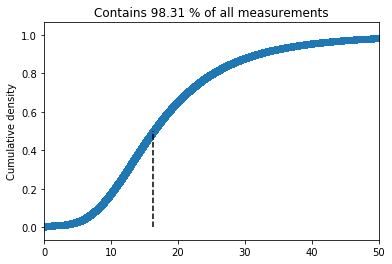

In [68]:
plot_ecdf(series=df_rides.velo, xlim=(0,50))

# Filter nach Trip-Duration


In [69]:
# FilterFunc
def filter_func(col_filter, value_filter, operation): 
    return df_rides.query(f"{col_filter}{operation}{value_filter}") 

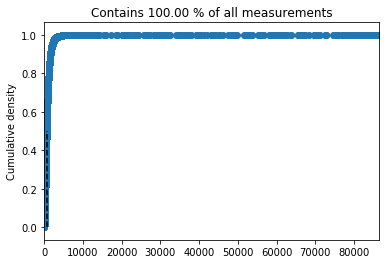

In [70]:
df_test=filter_func('trip_duration','60*60*24','<')
plot_ecdf(series=df_test.trip_duration, xlim=(0,86400))

In [71]:
df.trip_duration.describe()

count    1.428136e+06
mean     9.593878e+02
std      5.290710e+03
min      1.000000e+00
25%      3.980000e+02
50%      6.600000e+02
75%      1.067000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [72]:
# Nord 40.785741, Ost -73.962879
centerPoint=(587506.016,4515490.102)


In [73]:
df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'pickup_geom', 'dropoff_geom', 'pickup_x_utm', 'pickup_y_utm',
       'dropoff_x_utm', 'dropoff_y_utm', 'distance_Manhattan', 'Season',
       'DayOfYear', 'DayOfWeek', 'hour', 'day', 'month', 'year',
       'daylighthours', 'Holiday', 'velo'],
      dtype='object')

(4513490, 4517490)

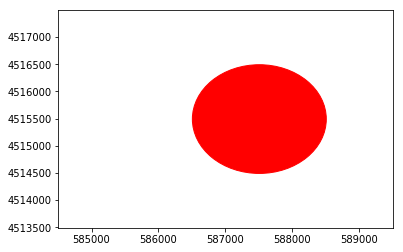

In [74]:

circle1 = plt.Circle(centerPoint, 1000, color='r')


fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()
ax.scatter
ax.add_artist(circle1)
ax.set_xlim([584506, 589506])
ax.set_ylim([4513490, 4517490])



(4475000, 4560000)

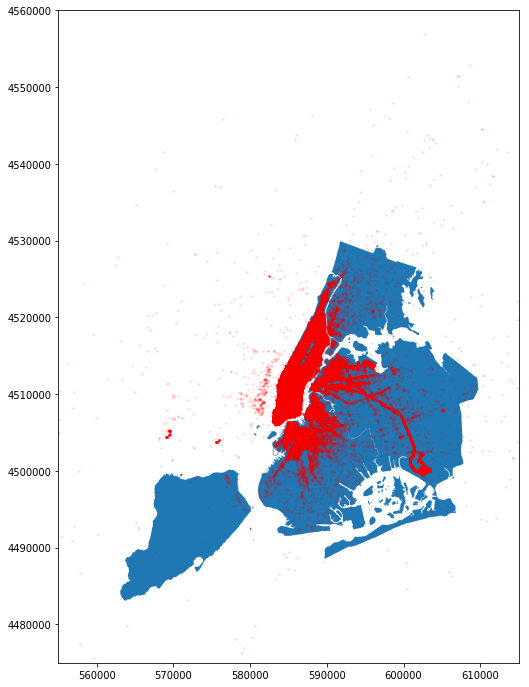

In [100]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.GeoDataFrame.from_file(nybb_path)
boros = boros.set_index('BoroCode')
boros = boros.sort_index().to_crs({'init': 'epsg:32618'})
boros
                                        
df_sample = df                                        
f,ax = plt.subplots(1,1,figsize=(12,12))                                        
boros.plot(ax=ax)
df_scatter = df_rides.sample(10000)
ax.scatter(df_sample.pickup_x_utm,df_sample.pickup_y_utm,alpha=0.1,c='red',marker='.',s=10)
ax.set_xlim([555000, 615000])
ax.set_ylim([4475000, 4560000])


(4475000, 4540000)

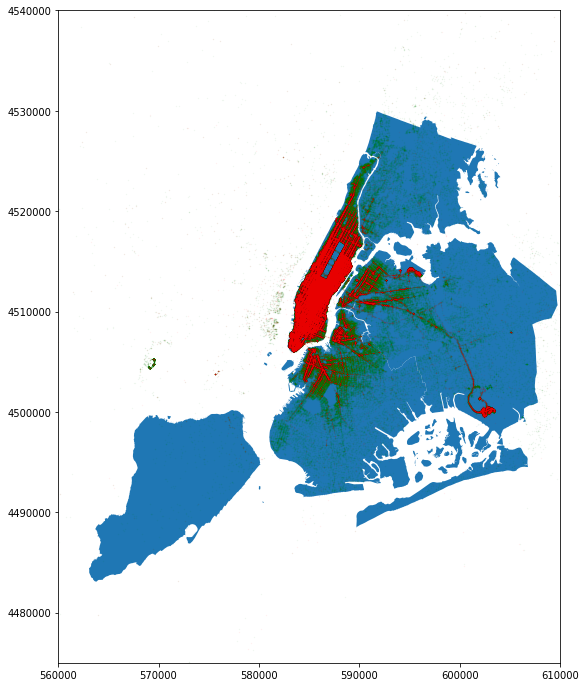

In [103]:
nybb_path = gpd.datasets.get_path('nybb')
boros = gpd.GeoDataFrame.from_file(nybb_path)
boros = boros.set_index('BoroCode')
boros = boros.sort_index().to_crs({'init': 'epsg:32618'})
boros
                                        
df_sample = df                                        
f,ax = plt.subplots(1,1,figsize=(12,12))                                        
boros.plot(ax=ax)
df_scatter = df_rides.sample(10000)
ax.scatter(df_rides.dropoff_x_utm,df_rides.dropoff_y_utm,alpha=0.05, marker='.',s=1,c='g')
ax.scatter(df_rides.pickup_x_utm,df_rides.pickup_y_utm,alpha=0.05, marker='.',s=1,c='r')
ax.set_xlim([560000, 610000])
ax.set_ylim([4475000, 4540000])

In [ ]:
f,ax = plt.subplots(1,1, figsize=(12,12))
df_scatter = df.sample(1000000,random_state=42)
boros.plot(ax=ax)
ax.plot(np.stack((df_scatter.pickup_x_utm,df_scatter.dropoff_x_utm)),np.stack((df_scatter.pickup_y_utm,df_scatter.dropoff_y_utm)),c='r'); 

          

KeyboardInterrupt: 

In [ ]:
print('tes')

In [76]:
def convert_projection_to_utm(df,col_x_source,col_y_source,
                              col_x_dest = 'x_utm', col_y_dest = 'y_utm',
                              projection_source=pyproj.Proj("+init=EPSG:4326"),
                              projection_dest=pyproj.Proj("+init=EPSG:32618")): 
    x,y = pyproj.transform(projection_source, projection_dest,df[col_x_source].values,df[col_y_source].values)
    return df.assign(**{col_x_dest:x,col_y_dest:y})

df = convert_projection_to_utm(df_rides,col_x_source='pickup_longitude',col_y_source='pickup_latitude',col_x_dest="pickup_x_utm",col_y_dest='pickup_y_utm')
df = convert_projection_to_utm(df_rides,col_x_source='dropoff_longitude',col_y_source='dropoff_latitude',col_x_dest="dropoff_x_utm",col_y_dest='dropoff_y_utm')
df.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,...,Season,DayOfYear,DayOfWeek,hour,day,month,year,daylighthours,Holiday,velo
id,,,,,,,,,,,,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,...,1,74,0,17,14,3,2016,11.864576,False,13.640105
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,...,2,164,6,0,12,6,2016,15.017241,False,13.258363
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,...,1,19,1,11,19,1,2016,9.675665,False,13.823795
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,...,2,97,2,19,6,4,2016,12.900760,False,13.802653
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,...,1,86,5,13,26,3,2016,12.409669,False,10.024146
